# Temperature change exposure using ERA weather and climatology, 2000-2015

- Project temperature changes between ERA interim and ERA climatology onto gridded population from NASA for 2000-2015
- Calculate global average as sum of exposure divided by total population

In [9]:
%matplotlib inline

from pathlib import Path
from datetime import date

import rasterio
import numpy as np
import scipy as sp
import pandas as pd
import xarray as xr
import geopandas as gpd 
import matplotlib.pyplot as plt

import cartopy
from cartopy import crs
from affine import Affine

import weather_ecmwf
import population_tools

from config import (DATA_SRC, ERA_MONTHLY_FILE, CLIMATOLOGY_FILE_RESAMP, 
                    SHAPEFILES_SRC, CLIMATOLOGY_FILE_MONTHLY, COUNTRY_POLY_SHP, POP_DATA_SRC)


# Load weather

In [3]:
era_weather = weather_ecmwf.weather_dataset(ERA_MONTHLY_FILE)
era_weather = era_weather.sel(time=slice('2000','2016'))
era_weather.load()

<xarray.Dataset>
Dimensions:               (latitude: 241, longitude: 480, time: 204)
Coordinates:
  * longitude             (longitude) float32 0.0 0.75 1.5 2.25 3.0 3.75 4.5 ...
  * latitude              (latitude) float32 90.0 89.25 88.5 87.75 87.0 ...
  * time                  (time) datetime64[ns] 2000-01-01 2000-02-01 ...
Data variables:
    surface_pressure      (time, latitude, longitude) float64 1.014e+05 ...
    tcw                   (time, latitude, longitude) float64 2.01 2.01 2.01 ...
    temperature_2m        (time, latitude, longitude) float64 245.6 245.6 ...
    temperature_dewpoint  (time, latitude, longitude) float64 242.6 242.6 ...
Attributes:
    Conventions:  CF-1.6
    history:      2017-04-28 10:49:11 GMT by grib_to_netcdf-2.2.0: grib_to_ne...

In [4]:
era_climatology = weather_ecmwf.climatology_dataset(CLIMATOLOGY_FILE_MONTHLY)
era_climatology.load()

<xarray.Dataset>
Dimensions:         (latitude: 241, longitude: 480, time: 12)
Coordinates:
  * longitude       (longitude) float32 0.0 0.75 1.5 2.25 3.0 3.75 4.5 5.25 ...
  * latitude        (latitude) float32 90.0 89.25 88.5 87.75 87.0 86.25 85.5 ...
  * time            (time) datetime64[ns] 1999-01-01 1999-02-01 1999-03-01 ...
Data variables:
    temperature_2m  (time, latitude, longitude) float64 245.8 245.8 245.8 ...

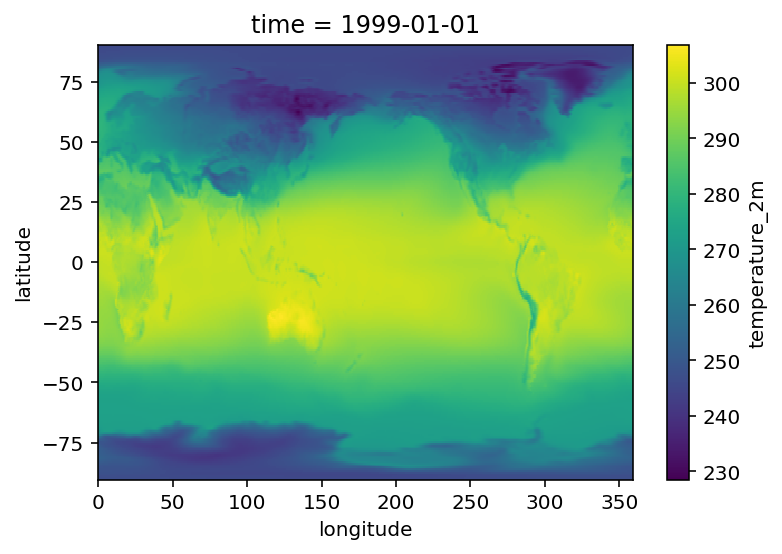

In [5]:
era_climatology.temperature_2m.sel(time='1999-01-01').plot()

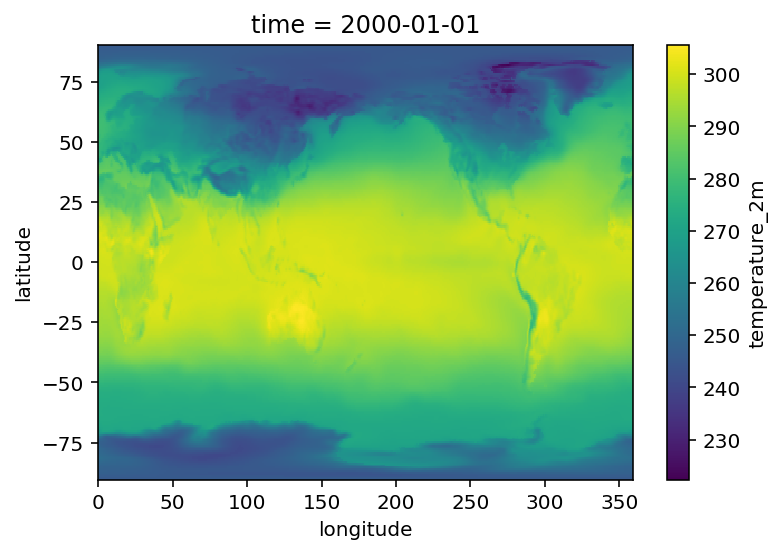

In [6]:
era_weather.temperature_2m.sel(time='2000-01-01').plot()

# Load population

In [7]:
pop_file = POP_DATA_SRC / 'population_2000-2020.nc'
pop_data = xr.open_dataset(str(pop_file))
pop_data

<xarray.Dataset>
Dimensions:     (latitude: 2175, longitude: 5400, time: 20)
Coordinates:
  * longitude   (longitude) float64 0.0 0.06667 0.1333 0.2 0.2667 0.3333 0.4 ...
  * latitude    (latitude) float64 85.0 84.93 84.87 84.8 84.73 84.67 84.6 ...
  * time        (time) datetime64[ns] 2000-01-01 2001-01-01 2002-01-01 ...
Data variables:
    population  (latitude, longitude, time) float64 0.0 0.0 0.0 0.0 0.0 0.0 ...

## Get ∆T for each month of each year

- Group by time.year and apply subtraction for each month

In [6]:
clim_t = era_climatology.temperature_2m.copy()

def sub_months(era_t_yr):
    clim_t['time'] = era_t_yr.time
    return era_t_yr - clim_t
    
delta_t = era_weather.temperature_2m.groupby('time.year').apply(sub_months)
delta_t = xr.Dataset({'delta_t_2m': delta_t},
                     coords={'longitude': delta_t.longitude,
                    'latitude': delta_t.latitude,
                    'time': delta_t.time
                    }
          )

## Get the mean delta for each year

In [7]:
year_mean = delta_t.resample('AS', dim='time')

### Reproject the yearly delta values onto the population grid

In [ ]:
years = list(range(2000, 2016))

with population_tools.PopulationProjector() as pop:
    yr_exposures = []
    for year in years:
        print(year)
        exposure = pop.project(year, year_mean.delta_t_2m.sel(time=f'{year}'))
        yr_exposures.append(exposure)
yr_exposures = xr.concat(yr_exposures, dim='time')

In [32]:
yr_exposures.name = 'year_mean_exposure'
yr_exposures.to_netcdf(str(DATA_SRC /'lancet' / 'year_mean_exposure.nc'))

In [34]:
global_mean = yr_exposures.mean(dim=['latitude', 'longitude'])
global_mean = global_mean.to_dataframe()

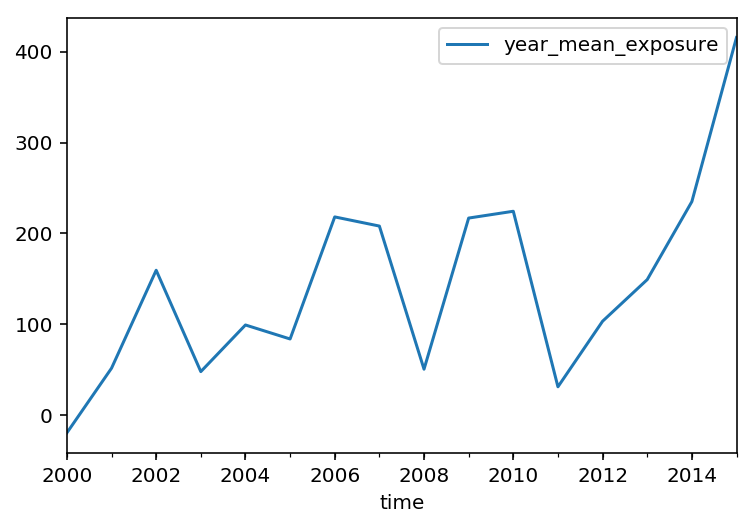

In [37]:
global_mean.plot()

In [18]:
# Wrangle to geotiff for easy viewing

pop_crs, pop_affine = population_tools.get_crs_and_affine()

exposure = exposure.values
exposure.shape = (exposure.shape[0], exposure.shape[1])
exposure = np.roll(exposure, exposure.shape[1]//2, axis=1)


with rasterio.open(str(DATA_SRC / 'lancet' / f'dt_exposure_mean_{year}.tif'),
                   'w',
                   driver='GTiff',
                   height=height,
                   width=width,
                   count=1,
                   dtype=exposure.dtype,
                   crs=pop_crs,
                   transform=pop_affine,
                   compress='lzw') as new_dataset:
    new_dataset.write(exposure, 1)

### Reproject onto the population density grid

In [12]:
years = list(range(2000, 2016))

with population_tools.PopulationProjector('population_density_2000-2020.nc') as pop:
    yr_dns_exposures = []
    for year in years:
        print(year)
        exposure = pop.project(year, year_mean.delta_t_2m.sel(time=f'{year}'))
        yr_dns_exposures.append(exposure)
yr_dns_exposures = xr.concat(yr_dns_exposures, dim='time')

2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015


In [14]:
yr_dns_exposures.name = 'year_mean_exposure_density'
yr_dns_exposures.to_netcdf(str(DATA_SRC /'lancet' / 'year_mean_exposure_density.nc'))

## Get the mean delta for each summer

In [15]:
# northern hemisphere
lat_north = delta_t.latitude[delta_t.latitude >= 0]
lat_south = delta_t.latitude[delta_t.latitude < 0]

# Summer North
summer_jja = delta_t.time[(delta_t['time.month'] == 6) | (delta_t['time.month'] == 7) | (delta_t['time.month'] == 8)]

# Summer South
summer_djf = delta_t.time[(delta_t['time.month'] == 12) | (delta_t['time.month'] == 1) | (delta_t['time.month'] == 2)]



In [16]:
nh_summer_mean = delta_t.sel(time=summer_jja).groupby('time.year').mean(dim='time')
sh_summer_mean = delta_t.sel(time=summer_djf).groupby('time.year').mean(dim='time')


In [18]:
summer_anom = xr.concat([nh_summer_mean.sel(latitude=lat_north),  
                         sh_summer_mean.sel(latitude=lat_south)], dim='latitude')

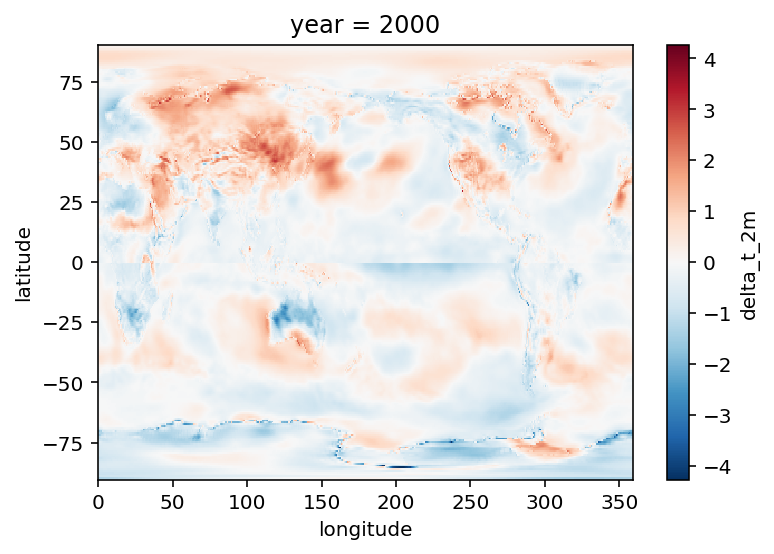

In [17]:
summer_anom.delta_t_2m.sel(year=2000).plot()

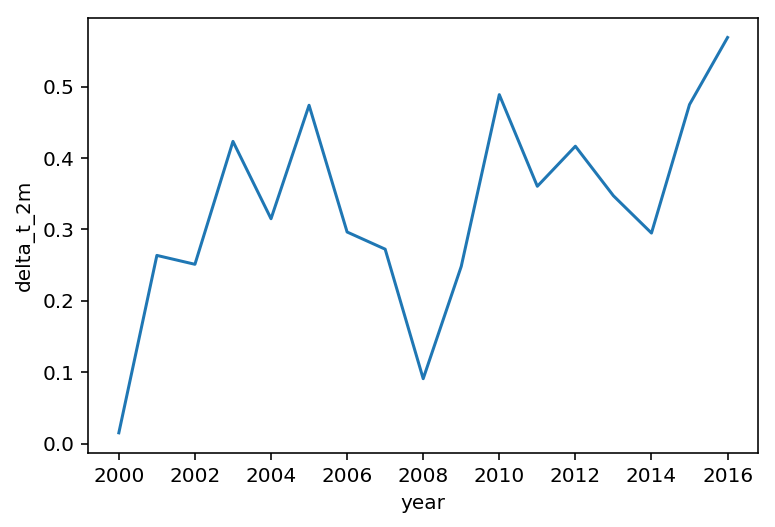

In [18]:
summer_anom.delta_t_2m.mean(dim=['latitude', 'longitude']).plot()

In [21]:

years = list(range(2000, 2016))

with population_tools.PopulationProjector() as pop:
    summer_exposures = []
    for year in years:
        print(year)
        exposure = pop.project(year, summer_anom.delta_t_2m.sel(year=year))
        summer_exposures.append(exposure)
summer_exposures = xr.concat(summer_exposures, dim='time')


2000
2000
2001
2001
2002
2002
2003
2003
2004
2004
2005
2005
2006
2006
2007
2007
2008
2008
2009
2009
2010
2010
2011
2011
2012
2012
2013
2013
2014
2014
2015
2015


In [23]:
summer_exposures = xr.concat(summer_exposures, dim='time')

In [24]:
summer_exposures.name = 'summer_exposure'
summer_exposures.to_netcdf(str(DATA_SRC /'lancet' / 'summer_exposure.nc'))

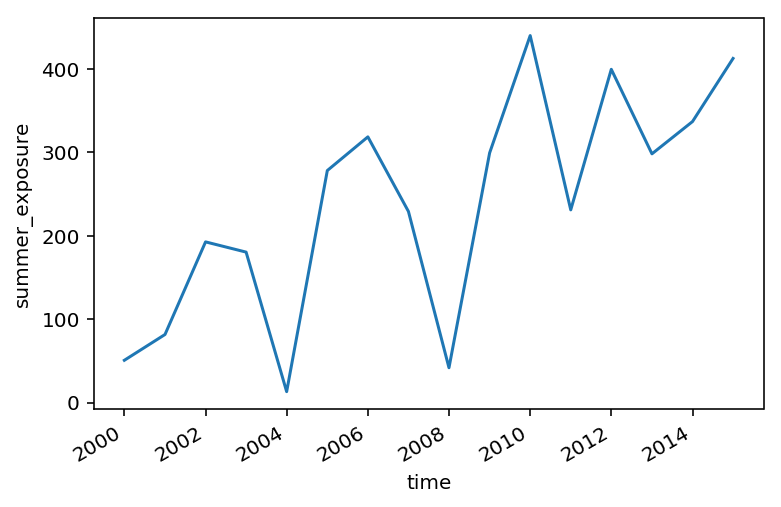

In [25]:
summer_exposures.mean(dim=['latitude', 'longitude']).plot()

In [20]:
years = list(range(2000, 2016))

with population_tools.PopulationProjector('population_density_2000-2020.nc') as pop:
    summer_exposures_dns = []
    for year in years:
        print(year)
        summer_exposures_dns.append(pop.project(year, summer_anom.delta_t_2m.sel(year=year)))
summer_exposures_dns = xr.concat(summer_exposures_dns, dim='time')



2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015


In [22]:
summer_exposures_dns.name = 'summer_exposure_density'
summer_exposures_dns.to_netcdf(str(DATA_SRC /'lancet' / 'summer_exposure_density.nc'))

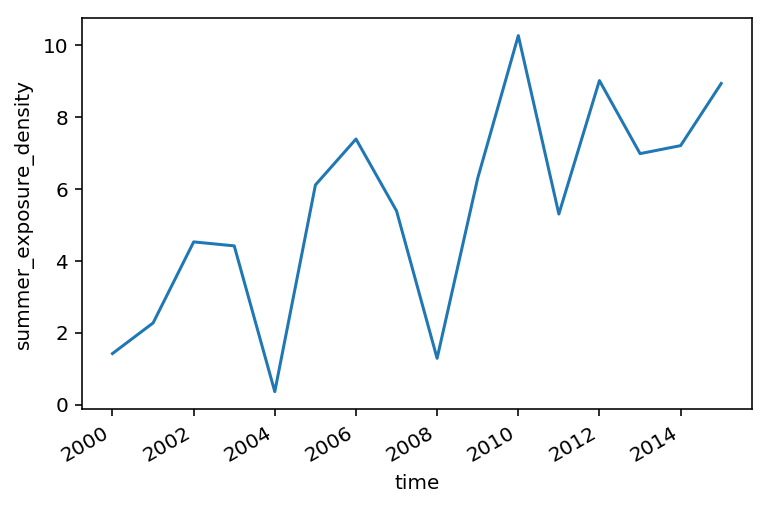

In [23]:
summer_exposures_dns.mean(dim=['latitude', 'longitude']).plot()